# Homework 2. Свертки и базовые слои

Модули

In [1]:
import random
from copy import deepcopy
import tqdm.notebook as tq
from typing import Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

import torchvision
import torchvision.transforms as transforms

In [2]:
eps = 1e-9

SEED = 161020204
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

numpy_rng = np.random.default_rng(SEED)
torch_rng = torch.Generator().manual_seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

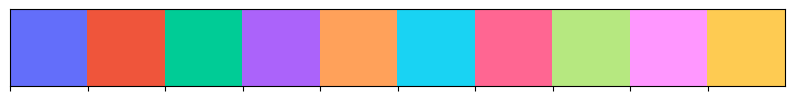

In [3]:
palette = px.colors.qualitative.Plotly

sns.palplot(palette)

---

Пример сетки, на которой будут проверяться новые слои

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_dataset.data.size(), train_dataset.targets.size()

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
class FlattenedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        image = image.view(-1)
        return image, label

In [6]:
train_dataset = FlattenedDataset(train_dataset)
test_dataset = FlattenedDataset(test_dataset)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

---

## Task 1

Это задание будет являться духовным наследником первого. Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой. На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. Однако все элементы, которые вы будете реализовывать, достаточно просты.

**Задача 1. (2 балла):** реализуйте слой BatchNorm (nn.BatchNorm).

**Задача 2. (2 балла):** реализуйте слой Linear (nn.Linear).

**Задача 3. (2 балла):** реализуйте слой Dropout(nn.Dropout)

**Задача 4. (2 балла):** реализуйте одно или более из:

- слой ReLU(nn.ReLU)
- слой Sigmoid(nn.Sigmoid)
- слой Softmax(nn.Softmax)

**Задача 5. (2 балла):** Вы получите по 1 дополнительному баллу за слой, если реализуете в рамках фреймворка из задания 3 прошлой работы.


---

### BatchNorm

In [8]:
class MyBatchNorm1d(nn.Module):

    def __init__(self, 
                 num_features: int, 
                 eps: float = 1e-8, 
                 momentum: float = 0.1
    ) -> None:
        super(MyBatchNorm1d, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('exp_avg_mean', torch.zeros(num_features))
        self.register_buffer('exp_avg_var', torch.ones(num_features))

    def __call__(self, input: torch.Tensor):
        # forward pass
        if self.training:
            if input.ndim == 2:
                dim = 0
            elif input.ndim == 3:
                dim = (0,1)
            input_mean = input.mean(dim, keepdim=True)
            input_var = input.var(dim, keepdim=True)
        else:
            input_mean = self.exp_avg_mean
            input_var = self.exp_avg_var
        x_hat = (input - input_mean) / torch.sqrt(input_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers (running mean and variance)
        if self.training:
            with torch.no_grad():
                self.exp_avg_mean = (1 - self.momentum) * self.exp_avg_mean + self.momentum * input_mean
                self.exp_avg_var = (1 - self.momentum) * self.exp_avg_var + self.momentum * input_var
        return self.out

### Linear

Реализация nn.Linear в [pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

Как работает [_calculate_fan_in_and_fan_out](https://github.com/pytorch/pytorch/blob/4557f6e339e7550b735067296ed479acc02e0487/torch/nn/init.py#L345)

In [9]:
class MyLinear(nn.Module):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True
    ) -> None:
        super(MyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # kaiming normal init for ReLU
        self.weight = nn.Parameter(torch.empty((in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        gain = 2 ** 0.5
        torch.nn.init.normal_(self.weight, mean = 0, std = gain / (self.in_features ** 0.5))
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean = 0, std = gain / (self.in_features ** 0.5))

    def __call__(self, input: torch.Tensor):
        self.out = input.matmul(self.weight)
        if self.bias is not None:
            self.out += self.bias
        return self.out

### Dropout

Реализация в [Pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#dropout1d)

Реализация в [Pytorch (cpp)](https://github.com/pytorch/pytorch/blob/a1b22e369bed57990a57f9efbae201570ad6b824/aten/src/ATen/native/Dropout.cpp#L62)

In [10]:
class MyDropout1d(nn.Module):

    def __init__(self, p: float = 0.5, inplace: bool = False) -> None:
        super(MyDropout1d, self).__init__()
        if p < 0 or p > 1:
            raise ValueError(f"dropout probability has to be between 0 and 1, but got {p}")
        self.p = p
        self.inplace = inplace
        self.training = True # БУДЕТ ЛИ ИЗМЕНЯТЬСЯ В РЕЖИМЕ model.eval()?

    def __call__(self, input: torch.Tensor):
        if self.training:
            inp_dim = input.dim()
            if inp_dim not in (2, 3):
                raise RuntimeError(f"dropout1d: Expected 2D or 3D input, but received a {inp_dim}D input. ")
            # is_batched = inp_dim == 3
            # if not is_batched:
            #     input = input.unsqueeze_(0) if self.inplace else input.unsqueeze(0)
            if self.p == 1:
                return torch.zeros_like(input)
            probs = torch.full_like(input, self.p)
            mask = torch.bernoulli(probs, generator=torch_rng)
            self.out = input.mul(mask)
            return self.out
        else:
            return input

### ReLU

In [11]:
class MyReLU(nn.Module):

    def __init__(self):
        super(MyReLU, self).__init__()

    def __call__(self, input):
        self.out = torch.where(input > 0, input, 0)
        # self.out = torch.relu(input)
        return self.out

### Softmax

In [12]:
class MySoftmax(nn.Module):

    def __init__(self, dim: Optional[int] = None):
        super(MySoftmax, self).__init__()
        self.dim = dim if dim is not None else 1 # нужна логика получше

    def __call__(self, input):
        maxes = torch.max(input, dim=1, keepdim=True)[0]
        x_exp = torch.exp(input - maxes)
        x_exp_sum = torch.sum(x_exp, dim=self.dim, keepdim=True)
        self.out = x_exp / x_exp_sum
        return self.out

---

### Экспериментальная сеть

In [13]:
model_seq = nn.Sequential(
    MyLinear(784, 256),   # Flattened MNIST images (28x28) -> hidden layer
    MyBatchNorm1d(256),   # BatchNorm
    MyReLU(),             # ReLU activation
    MyDropout1d(p=0.5),    # Dropout layer
    MyLinear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    MySoftmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

In [14]:
# (784 * 256 + 256) + 256 * 2 + (256 * 10 + 10)
sum(p.numel() for p in model_seq.parameters())

204042

In [15]:
def train_model_sequential(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

In [16]:
train_model_sequential(model_seq, train_loader, criterion, optimizer)

Epoch 1/5, Loss: 1.5998559447606404
Epoch 2/5, Loss: 1.5424904745101928
Epoch 3/5, Loss: 1.5301774183909098
Epoch 4/5, Loss: 1.5216965227127075
Epoch 5/5, Loss: 1.516130871073405


In [17]:
evaluate_model(model_seq, test_loader)

Accuracy: 96.34%


Торчевская аналогичная сеть для сравнения

In [18]:
model_seq = nn.Sequential(
    nn.Linear(784, 256),   # Flattened MNIST images (28x28) -> hidden layer
    nn.BatchNorm1d(256),   # BatchNorm
    nn.ReLU(),             # ReLU activation
    nn.Dropout1d(p=0.5),    # Dropout layer
    nn.Linear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    nn.Softmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

In [19]:
train_model_sequential(model_seq, train_loader, criterion, optimizer)

Epoch 1/5, Loss: 1.9341435103098552
Epoch 2/5, Loss: 1.9134720966974894
Epoch 3/5, Loss: 1.900992161432902
Epoch 4/5, Loss: 1.9015678155899047
Epoch 5/5, Loss: 1.8977774666468303


In [20]:
evaluate_model(model_seq, test_loader)

Accuracy: 96.32%
